In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion

In [2]:
class SVM:
    def __init__(self, filename, sep: str, C, e: float, kernel_type: str, sigma: float = 5e-2):
        df = pd.read_csv(filename, sep=sep, header=None)
        X = df[[0, 1]].to_numpy()
        X.mean(axis=0)
        X.std(axis=0)
        self.X = (X - X.mean(axis=0)) / X.std(axis=0)
        self.y = df[[2]].to_numpy().reshape((-1))
        self.X_train, self.X_test, \
        self.y_train, self.y_test, \
        self.indices_train, self.indices_test = train_test_split(self.X, self.y, 
                                                                 np.arange(self.X.shape[0]), 
                                                                 test_size=0.25, 
                                                                 random_state=1,stratify=self.y)
        self.n = self.X_train.shape[0]
        self.kernel_type = kernel_type
        self.sigma = sigma
        kernel = np.empty((self.n, self.n))
        if self.kernel_type == 'linear':
            # Compute linear kernel matrix
            #kernel = np.dot(self.X_train , np.transpose(self.X_train))
            for i in range(self.n):
                for j in range(self.n):
                    kernel[i, j] = np.dot(self.X_train[i], self.X_train[j])
        else:
            # Compute Gaussian kernel matrix
            kernel = self.__gaussian_kernel()
        # Augmented kernel matrix
        self.K_aug = kernel + 1.0
        # Set step size
        self.gamma = np.empty(self.n)
        for i in range(self.n):
            self.gamma[i] = 1.0 / (self.K_aug[i, i] + 1e-4)
        # Regularization
        self.C = C
        # Treshold
        self.e = e
        self.alpha = None
        
    def __gaussian_kernel(self):
        kernel = np.empty((self.n, self.n))
        for i in range(self.n):
            norm = LA.norm(self.X_train - self.X_train[i], axis=1)
            kernel[:, i] = np.exp((norm * norm) / (-2 * self.sigma))
        return kernel
                
    def fit(self):
        epoc = 0
        alpha_ts = []
        alpha_ts.append(np.zeros(self.n))
        while True:
            alpha = alpha_ts[-1]
            # TODO can be vectorized
            for k in range(self.n):
                # update kth component of alpha
                alpha[k] = alpha[k] + self.gamma[k]*(1.0 - self.y_train[k]*(self.K_aug[:, k] * self.y_train * alpha).sum())
                # project into [0, C]
                if alpha[k] < 0.0:
                    alpha[k] = 0.0
                if alpha[k] > self.C:
                    alpha[k] = self.C
            alpha_ts.append(alpha)
            epoc += 1
            norm = LA.norm(alpha_ts[-1] - alpha_ts[-2])
            if norm < self.e:
                break
            if epoc % 10 == 0:
                print(f'epoc: {epoc}   norm: {norm}')
        self.alpha = alpha
        return self.alpha, epoc
    
    def predict(self, X):
        # Predict for all X
        assert self.alpha is not None, "call 'fit' first"
        
        if self.kernel_type == 'linear':
            r = np.empty(X.shape[0])
            for i in range(X.shape[0]):
                r[i] = ((np.dot(self.X_train, X[i]) + 1.0) * self.y_train * self.alpha).sum()
            return np.sign(r)
        # Gaussian 
        kernel = np.empty((X.shape[0], self.n))
        for i in range(X.shape[0]):
            norm = LA.norm(self.X_train - X[i], axis=1)
            kernel[i, :] = np.exp((norm * norm) / (-2 * self.sigma)) + 1.0
        return np.sign(np.dot(kernel, self.y_train * self.alpha))
    
    def plot_decision_regions(self, resolution=0.02):
        # setup marker generator and color map
        markers = ('o', 's', '^', 'v', '<')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(self.y))])

        # plot the decision surface
        x1_min, x1_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        x2_min, x2_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
        lab = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        lab = lab.reshape(xx1.shape)
        plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # plot class examples
        for idx, cl in enumerate(np.unique(self.y)):
            plt.scatter(x=self.X[self.y == cl, 0], 
                        y=self.X[self.y == cl, 1],
                        alpha=0.8, 
                        c=colors[idx],
                        marker=markers[idx], 
                        label=f'Class {cl}', 
                        edgecolor='black')

        # highlight test examples
        # plot all examples
        X_test, y_test = self.X[self.indices_test, :], self.y[self.indices_test]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')  

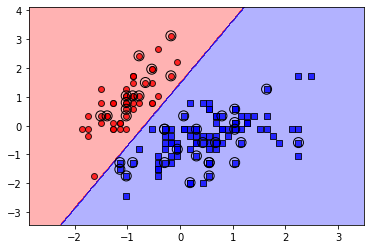

In [3]:
classifier = SVM('iris-slwc.txt', ',', 10.0, 1e-4, 'linear')
classifier.fit()
classifier.plot_decision_regions()


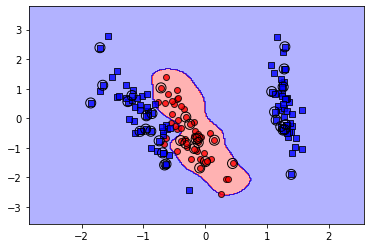

In [4]:
classifier = SVM('iris-PC.txt', ' ', 10.0, 1e-4, 'quadratic', 1e-1)
classifier.fit()
classifier.plot_decision_regions()